# 在强化学习中，需要进行随机采样，比如说泊松分布、正态分布等，所以就要用概率论

In [3]:
import torch as t
import torch.distributions as distributions

fair_probs=t.ones([6])/6
#torch.multinominal方法可以根据给定权重对数组进行多次采样，返回采样后的元素下标
a=distributions.multinomial.Multinomial(1,fair_probs).sample()
# 取10个样本，不是用for循环来调用上面的一行，而是多线程。
b=distributions.multinomial.Multinomial(10, fair_probs).sample()
print(a,b)

tensor([0., 0., 1., 0., 0., 0.]) tensor([1., 3., 0., 4., 1., 1.])


# 分布的期望和方差

In [14]:
def p(x:int)->float:
    probabilities=[0.1,0.2,0.3,0.4]
    return probabilities[x]
def f(x:int)->int:
    values=[1,2,3,4]
    return values[x]

#compute the expectation
sum=0
for x in range(4):
    sum+=p(x)*f(x)
print("expectation:{}".format(sum))
expectation=sum
#compute the variance
# var[x]=E[x^2]-E[x]^2

# Naive Method
sum=0
for x in range(4):
    sum += p(x)*(f(x)-expectation)*(f(x)-expectation)
print("variance:",sum)
# use var[x]=E[x^2]-E[x]^2

sum=0
for x in range(4):
    sum += (p(x)*f(x)*f(x))
print("variance:", sum-expectation*expectation)


expectation:3.0
variance: 1.0
variance: 1.0


# .Sample() and .Resample() method
- 在Soft Actor Critic中用到了最大熵的方法
- 熵可以粗略的认为是一个衡量随即变量不确定性的量。比如抛硬币，如果每一次抛几乎都是正面，那么它的熵就很低。 如果出现正面和出现反面的概率大致相同，则它具有很高的熵。
- ![](../entropy.png)

In [3]:
# define a normal distributinon
import torch as t
from torch.distributions import Normal

normal_dist= Normal(t.tensor([0.,2.]),1)
normal_dist.sample()

tensor([0.1819, 3.3077])

In [10]:
# sample for n times
normal_dist.sample_n((10))

tensor([[-0.0970,  0.8150],
        [ 2.2514,  1.1635],
        [ 2.2645,  2.1888],
        [ 0.4129,  1.8708],
        [-0.9687,  1.2213],
        [ 0.4118,  2.2321],
        [ 1.2437,  0.7919],
        [ 0.2428,  2.4748],
        [ 0.6195,  2.2070],
        [ 0.5589,  2.1718]])

In [27]:
# log probablility
s=normal_dist.sample()
print("value s is",s)
# get the probabilities 
print("probability:",normal_dist.log_prob(s).exp())

# ********# 
normal_dist.log_prob(t.tensor([0.,2.])).exp()


value s is tensor([1.4231, 1.4697])
probability: tensor([0.1449, 0.3466])


tensor([0.3989, 0.3989])

In [24]:
# resample
normal_dist.rsample()

tensor([-1.4999,  3.3254])

# 计算熵

In [1]:
import torch as t

# 假设硬币两面，正面反面的概率是个tensor
a = t.tensor([0.5,0.5])
b=t.tensor([0.0001,0.9999])
c=t.ones((10))/10
def compute_entropy(probability:t.Tensor)->t.Tensor:
    return -(probability.log()*probability).sum()/probability.shape[0]

print(compute_entropy(a),compute_entropy(b),compute_entropy(c))

tensor(0.3466) tensor(0.0005) tensor(0.2303)


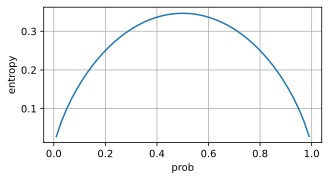

In [2]:
# draw pictures we can find that the largest number occured when probability is 0.5
import sys
sys.path.append("../")
from pltutils import plot

ls=t.linspace(0.01,0.99,50)
probs= [t.tensor([p,1-p]) for p in ls]
entropy=[compute_entropy(p).item() for p in probs]
[tensor[0].item() for tensor in probs]
plot([tensor[0].item() for tensor in probs],entropy
, 'prob', 'entropy', figsize=(5, 2.5))

# SAC 中的Reparameterization
## squashed Gaussian policy

In [23]:
import torch as t
from torch.distributions import Normal
# 如何计算policy的entropy？
mean,std=1,1.5
dist=Normal(mean,std)
x=dist.sample()
log_prob=dist.log_prob(x)
print("x:{},\nlog_prob:{}".format(x,log_prob))

# 但是我们的action是有界的，所以加上t.tanh()进行限制边界
# 已知x原始的概率分布f(x),而且y=g(x)，为严格单调函数，g'存在，h(·)为g的反函数，求f(y)
# https://blog.csdn.net/bingfeiqiji/article/details/81908948
# https://zhuanlan.zhihu.com/p/90671492
# 1、严格增函数：
# Fy（y）=P（Y<=y）=P（g(X)<=y）
#       =P（X<=h(y)）=Fx(h(y))
# fy(y)=fx(h(y))*h'(y)
# 2、严格减函数：
# Fy（y）=P（Y<=y）=P（g(X)<=y）
#       =P（X>=h(y)）=1-Fx(h(y))
# fy(y)=-fx(h(y))*h'(y) [h'(y)是负数，结果仍为正]
y_t=t.tanh(x)
action_scale=1
log_prob-=t.log(action_scale*(1-y_t.pow(2)))
print("y:{},\nlog_prob:{}".format(y_t,log_prob))

x:1.2518424987792969,
log_prob:-1.3384979963302612
y:0.8487995266914368,
log_prob:-0.06388580799102783



# 计算SAC中的H(a)，使用采样的方法



In [2]:
import numpy as np

pa= np.array(0.1)
pb=np.array(0.2)

ha=- np.log(pa)
hb = - np.log(pb)
print(ha,hb)

# actor loss = -(H(a)+(state_action value))

2.3025850929940455 1.6094379124341003
